# Classificando notícias com Redes Neurais Recorrentes 📰
Imagine que temos o desafio de organizar diversos tipos de notícias por assuntos, como você faria? Basicamente podemos classificar uma notícia dado algum contexto, por exemplo:

"Pela quarta rodada do Campeonato Italiano, a Roma não tomou conhecimento do Empoli neste domingo e venceu pela primeira vez na competição."

Com base nesse contexto, poderiamos classificar essa notícia como do tipo "Esportes", certo? E por que sabemos disso? Bem, podemos observar algumas palavrinhas chaves tal como "campeonato" e "competição".

Nessa aula, temos o desafio de ensinar uma rede neural recorrente realizar esse tipo de trabalho! Classificar notícias com base em textos.

Como bem já sabemos, as redes neurais recorrentes aprende com ela mesma (assim como nós humanos aprendemos com nossos erros). Basicamente, esse tipo de arquitetura aprende não só com os dados de entrada mas também com as próprias saídas da rede (muito parecido com um looping de aprendizado, por isso chamamos de redes recorrentes). Como nesse cenário precisamos de uma sequência de palavras para fazer sentido ao contexto, as RNNs podem ser uma boa alternativa! Vamos codar? 😀


Primeiro passo, vamos importar as bibliotecas necessárias para esse trabalho:

In [3]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os

# Para NLP
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para deep learning e validação do modelo
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcelocardoso/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carregando a base de dados:

Aqui temos um arquivo csv que contém algumas notícias já rotuladas em categorias. Vamos importar essa base de dados aqui dentro do notebook.

In [4]:
df = pd.read_csv("bbc-text.csv", sep=",")

df_2 = df.copy()

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


Que interessante, podemos logo observar que temos duas colunas. Uma de texto e outra de categoria. Perceba aqui que temos uma base histórica já classificada para nós, então logo já estou pensando que podemos criar um aprendizado de máquina para aprender esses padrões. Vamos analisar quantas linhas temos na base?

In [6]:
df.shape

(2225, 2)

ok! um tamanho bacana para criar um aprendizado de máquina! 😀

Vamos dar uma conferida agora em quantas categorias temos na base?

In [7]:
df['category'].nunique()

5

In [8]:
set(df['category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

Um passo importante é analisar se existem dados nulos, então vamos conferir!

In [9]:
df.isnull().sum()

category    0
text        0
dtype: int64

Sem dados nulos, então vamos entender quais são as categorias presentes na base.

## Conhecendo os dados!

Para visualizar melhor as categorias e proporção de cada uma delas, nada melhor como um gráfico de barras! Vamos plotar um gráfico e analisar as categorias presentes na base.

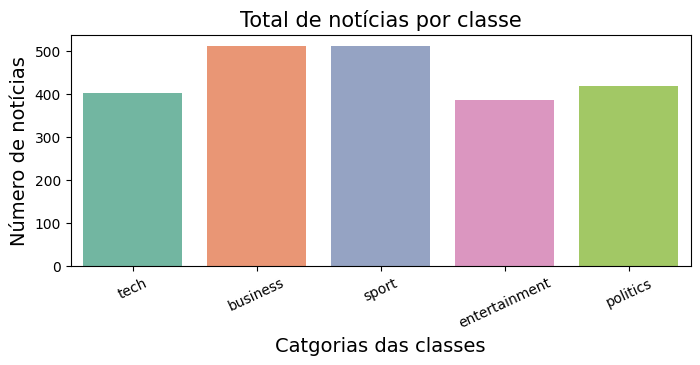

In [11]:
cores = sns.color_palette('Set2')
plt.figure(figsize=(8,3))
sns.countplot(data=df, x='category', palette=cores)
plt.title("Total de notícias por classe", size=15)
plt.xlabel("Catgorias das classes", size=14)
plt.xticks(rotation=25)
plt.ylabel("Número de notícias", size=14)
plt.show()

Perfeito! Aqui identificamos que temos 5 categorias e não possui um desequilíbrio tão desproporcional na base, o que já nos facilita muito para a construção do algoritmo.

## Pré-processamento de texto
Agora que já conhecemos nossos dados, vamos trabalhar com uma etapa importante nessa aula! O pré-processamento de texto.

Como você pode observar, esse contexto é diferente do que estamos acostumados a trabalhar em modelos de machine learning tradicional. Aqui estamos trabalhando com palavras, o que nos leva a realizar um tratamento diferente! Vamos precisar aplicar algumas etapas antes de realizar a nossa RNN:

* Tokenization (separar o texto em "tokens", ou seja, separar parte por parte).
* One-Hot encoding (representar variáveis categóricas como vetores binários).
* Pad sequencing (Garante sequências de comprimento uniforme adicionando zeros nas sequencias de palavas para manter sequencias uniformes)
* Embedding layer (Word2Vec) (mapear palavras em vetores)

### Limpeza dos dados 🧹

Antes de iniciar as etapas de pré-processamento que citei anteriormente, vamos precisar limpar os dados. Vamos ciar uma função que realize a etapa de limpeza do texto utilizando alguns REGEX, remoção de stop words e lematizar algumas palavras.

Para contextuallizar o que fazem essas técnicas, vamos falar um pouquinho mais sobre elas.

## Regex
Pode ser definida como uma **forma flexível de identificar determinada cadeia de caractere** para nosso interesse. Uma cadeia pode ser um caractere específico, uma palavra ou um padrão.
No Python, o módulo **re** provê um analisador sintático que permite o uso de tais expressões. Os padrões definidos através de caracteres que tem significado especial para o analisador.

## Stop-words
Essa técnica consiste na **remoção de ruídos** do texto que são menos evidentes que pontuações, como os conectivos “que”, “o”, “a”, “de”, entre outros. Normalmente é um conjunto composto por artigos, advérbios, preposições e alguns verbos.

## Lematização
Basicamente é um processo que determina uma única “raiz” para a palavra, independente de suas diferenças superficiais.


In [12]:
def limpeza_texto(text):
    # regex para limpar o texto
    whitespace = re.compile(r"\s+")                            # encontrando espaços em branco
    user = re.compile(r"(?i)@[a-z0-9_]+")                      # encontrar menções de usuários, exemplo @usuario
    text = whitespace.sub(' ', text)                           # substitui espaços em branco por ' '
    text = user.sub('', text)                                  # remove todas as menções de usuário encontradas no texto
    text = re.sub(r"\[[^()]*\]","", text)                      # remove o conteúdo dentro de colchetes, incluindo os colchetes
    text = re.sub("\d+", "", text)                             # remove todos os dígitos numéricos do texto
    text = re.sub(r'[^\w\s]','',text)                          # remove todos os caracteres que não são palavras (letras e números) ou espaços em branco.
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text) # remove menções de usuário, hashtags e URLs.
    text = text.lower()                                        # texto para minusculo

    # removendo as stop words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

Vamos ver como ficaram nossos dados?

In [13]:
print("Texto antes da limpeza:\n",df['text'][0])
print("---"*100)
print("Texto depois da limpeza:\n",limpeza_texto(df['text'][0]))

Texto antes da limpeza:
 tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are als

Vamos aplicar agora essa função de limpeza para toda a base de dados:

In [14]:
# Aplicando a função no dataframe inteiro
df['text'] = df['text'].apply(limpeza_texto)

Validando antes e depois da limpeza dos dados:

In [15]:
# comprimento do total de caracteres antes e depois da limpeza dos dados de texto
antigo_total_caracter = df_2['text'].apply(len).sum()
novo_total_caracter = df['text'].apply(len).sum()

print(f"Tamanho de caracteres antes da limpeza: {antigo_total_caracter}")
print(f"Tamanho de caracteres depois da limpeza: {novo_total_caracter}")

Tamanho de caracteres antes da limpeza: 5035033
Tamanho de caracteres depois da limpeza: 3280729


Show! Já diminuimos bastante o tamanho da dimensão dos dados com as técnicas de limpeza!

In [16]:
# comprimento do total de palavras antes e depois da limpeza dos dados de texto
antigo_total_palavras = df_2['text'].apply(lambda x: len([i for i in x.split()])).sum()
novo_total_palavras = df['text'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Total de palavras antes da limpeza: {antigo_total_palavras}")
print(f"Total de palavras depois da limpeza: {novo_total_palavras}")

Total de palavras antes da limpeza: 868407
Total de palavras depois da limpeza: 488645


Logo, também diminuimos o tamanho de palavras no vocabulario!

# Entrando no preparo dos dados! 📏

## Tokenização e vetorização

### Tokenização
A tokenização é uma etapa inicial no processo de NLP para dividir frases de texto em palavras ou tokens menores. Por exemplo: "O time venceu a partida" ficaria "o", "time", "venceu", "a", "partida".

E porque precisamos tokenizar?

É necessário para identficar cada uma das palavras contidas na base.

### Vetorização
A máquina não entende texto ou palavras, portanto, dados de texto ou tokens devem ser **convertidos em índices de palavras ou vetores de palavras** para processar texto e construir modelos. Por exemplo,  "o: 1", "time: 2", "venceu: 3", "a: 4", "partida: 5".



In [17]:
# workflow de tokenização e vetorização
# codificação one-hot de nível de palavra para dados de amostra

samples = list(df['text'][:5].values)  # amostras dos primeiros cinco documentos do nosso conjunto de dados

token_index = {} # cria um índice de tokens nos dados
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # atribuindo índice exclusivo para cada palavra única

max_length = 15 # Define um valor máximo para o comprimento das sequências. Todas as sequências terão esse comprimento, e as palavras adicionais serão truncadas se necessário

results = np.zeros(shape=(len(samples),   # resultados serão armazenados neste array multidimensional de zeros com as dimensões obtidas pelo tamanho das amostras e o tamanho máximo de comprimento
                          max_length,     # Esta matriz será usada para armazenar a codificação one-hot das palavras em cada sequência de amostra
                          max(token_index.values()) +1))

print("Shape de resultados armazenados:", results.shape)
print("Índice de token de palavras únicas: \n", token_index)

# criando a matriz one hot econdig
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape de resultados armazenados: (5, 15, 680)
Índice de token de palavras únicas: 
 {'tv': 1, 'future': 2, 'hand': 3, 'viewers': 4, 'home': 5, 'theatre': 6, 'systems': 7, 'plasma': 8, 'highdefinition': 9, 'tvs': 10, 'digital': 11, 'video': 12, 'recorders': 13, 'move': 14, 'live': 15, 'room': 16, 'way': 17, 'people': 18, 'watch': 19, 'will': 20, 'radically': 21, 'different': 22, 'five': 23, 'years': 24, 'time': 25, 'accord': 26, 'expert': 27, 'panel': 28, 'gather': 29, 'annual': 30, 'consumer': 31, 'electronics': 32, 'show': 33, 'las': 34, 'vegas': 35, 'discuss': 36, 'new': 37, 'technologies': 38, 'impact': 39, 'one': 40, 'favourite': 41, 'pastimes': 42, 'us': 43, 'lead': 44, 'trend': 45, 'program': 46, 'content': 47, 'deliver': 48, 'via': 49, 'network': 50, 'cable': 51, 'satellite': 52, 'telecoms': 53, 'company': 54, 'broadband': 55, 'service': 56, 'providers': 57, 'front': 58, 'portable': 59, 'devices': 60, 'talkedabout': 61, 'ces': 62, 'personal': 63, 'dvr': 64, 'pvr': 65, 'settop': 

## One Hot Enconding e indexação one-hot de dados de treinamento e teste


In [18]:
# Aplicando LabelEncoder nas categorias para converter rótulos de classes de texto ou categorias em números inteiros
X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

print("tamanho dos dados de entrada: ", X.shape)
print("tamanho da variável alvo: ", y.shape)

# Seprando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Criando a tokenização
# Tendo agora as palavras em uma grande lista (1000), usamos a classe Tokenizer para tokenização das palavras e criação de um vocabulário
# com as 1000 palavras mais frequentes no texto(parâmetro num_words do Tokenizer):
tokenizer = Tokenizer(num_words=1000, oov_token='<00V>')  # OOV = out of vocabulary (fora de vocabulário)
tokenizer.fit_on_texts(X_train) # construindo o índice de palavras

# Preenchimento de dados de entrada de texto X_train
train_seq = tokenizer.texts_to_sequences(X_train) #converte strings em listas inteiras
train_padseq = pad_sequences(train_seq, maxlen=200) # preenche as listas de inteiros para o tensor de inteiros 2D
# maxlen define o comprimento máximo desejado para as sequências após o preenchimento (padding)

# preenchimento de dados de entrada de texto X_test
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=200)

word_index = tokenizer.word_index
max_words = 1500  # número total de palavras a serem consideradas na camada de incorporação
total_words = len(word_index)
maxlen = 200 # comprimento máximo da sequência
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
print("Tamanho do índice de palavras:", total_words)

tamanho dos dados de entrada:  (2225,)
tamanho da variável alvo:  (2225,)
Tamanho do índice de palavras: 22935


In [19]:
total_words

22935

## Aplicando Word Embeddings
O que é a técnica de word embeddings?

Essa técnica consiste em **transformar palavras em vetores**, permitindo que o computador processe o significado semântico das palavras. Esses vetores numéricos representam a semântica da palavra com base em sua relação com outras palavras em um corpus de treinamento. Palavras semanticamente semelhantes têm vetores de embedding semelhantes.
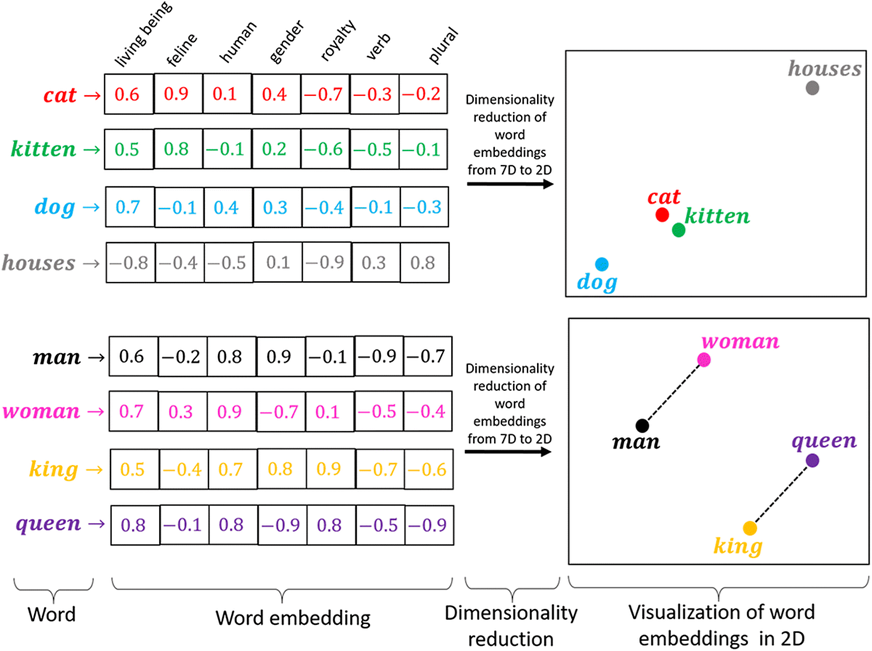



Os embeddings de palavras são uma alternativa à codificação one-hot juntamente com a redução da dimensionalidade

A biblioteca Keras possui uma camada de embeddings que representa palavras de um determinado corpus de texto.

tf.keras.layers.Embedding( input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None, kwargs )

Argumentos principais:

1) input_dim - Tamanho do vocabulário - comprimento do índice da palavra

2) output_dim - Dimensão de saída da representação da palavra

3) comprimento de entrada - comprimento máximo da sequência de entrada do documento

## Finalmente, aplicando a RNN! 📰

A rede numérica recorrente processa sequências iterando através dos elementos da sequência e mantendo um estado contendo informações relativas ao que viu até agora. Na verdade, uma RNN é um tipo de rede numérica que possui um loop interno.

In [20]:
# utilizando a SimpleRNN em conjunto com embeddings

model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen)) # camada de embeddings, utilizando o total de palavras do corpus, com 70 neuronios de dimensão e entrada do tamanho da rede é de maxlen (200)
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True))) # cada unidade de tempo da RNN tem acesso a informações de contexto tanto passadas quanto futuras
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True))) # return_sequences=True indica que essa camada retorna sequências em vez de um único vetor
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 70)           1605450   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          17280     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [21]:
model.compile(optimizer='adam', # Adam, que é um algoritmo de otimização amplamente utilizado para ajustar os pesos da rede neural durante o treinamento.
            loss='categorical_crossentropy', # função de perda a ser minimizada durante o treinamento
            metrics=['accuracy'] # métrica de avaliação para monitorar durante o treinamento
            )
# Configurando early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Monitora a métrica de precisão durante o treinamento
                                             patience=3, # número de épocas que o treinamento pode continuar sem melhorar a métrica monitorada antes de parar
                                              verbose=1, # mostra mensagens de progresso durante o treinamento
                                              mode='min' # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"
                                             )
# salva o modelo com os melhores valores encontrados durante o treinamento
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# treinando o modelo
history = model.fit(train_padseq, y_train,
                   batch_size=120,
                    epochs=15,
                    validation_split=0.2
                   )

# validando o modelo
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 [==============================] - 5s 264ms/step - loss: 1.8493 - accuracy: 0.1826 - val_loss: 1.6560 - val_accuracy: 0.1461
Epoch 2/15
12/12 [==============================] - 3s 228ms/step - loss: 1.7728 - accuracy: 0.2001 - val_loss: 1.6479 - val_accuracy: 0.2191
Epoch 3/15
12/12 [==============================] - 3s 248ms/step - loss: 1.7441 - accuracy: 0.1938 - val_loss: 1.6226 - val_accuracy: 0.2219
Epoch 4/15
12/12 [==============================] - 3s 234ms/step - loss: 1.7166 - accuracy: 0.2114 - val_loss: 1.6213 - val_accuracy: 0.2051
Epoch 5/15
12/12 [==============================] - 3s 242ms/step - loss: 1.7148 - accuracy: 0.2205 - val_loss: 1.6220 - val_accuracy: 0.2135
Epoch 6/15
12/12 [==============================] - 3s 231ms/step - loss: 1.6853 - accuracy: 0.2191 - val_loss: 1.6159 - val_accuracy: 0.2107
Epoch 7/15
12/12 [==============================] - 3s 234ms/step - loss: 1.6597 - accuracy: 0.2296 - val_loss: 1.6223 - val_accuracy: 0.2163
Epoch 

Podemos analisar que essa rede neural recorrente simples não funcionou tão bem assim, certo? 😞 Acredito que precisamos dar um upgrade nela!

O que pode ter ocorrido aqui nesse cenário é o **vanishing gradient problem**. Esse fenomeno ocorre quando o gradiente desaparece conforme ocorre o backpropagation. É isso que leva ao “esquecimento” das informações mais antigas devido às transformações pelas quais os dados passam ao atravessar uma RNN.

Para solucionar esse tipo de deficiência das RNNs tradicionais, te apresento a rede neural LSTM Redes Long Short-Term Memory (memória de curto e longo prazo).

Antes de dar um upgrade no modelo com LSTM, vamos analisar os resultados!


In [22]:
model.save("model.h5") # salvando o modelo 1

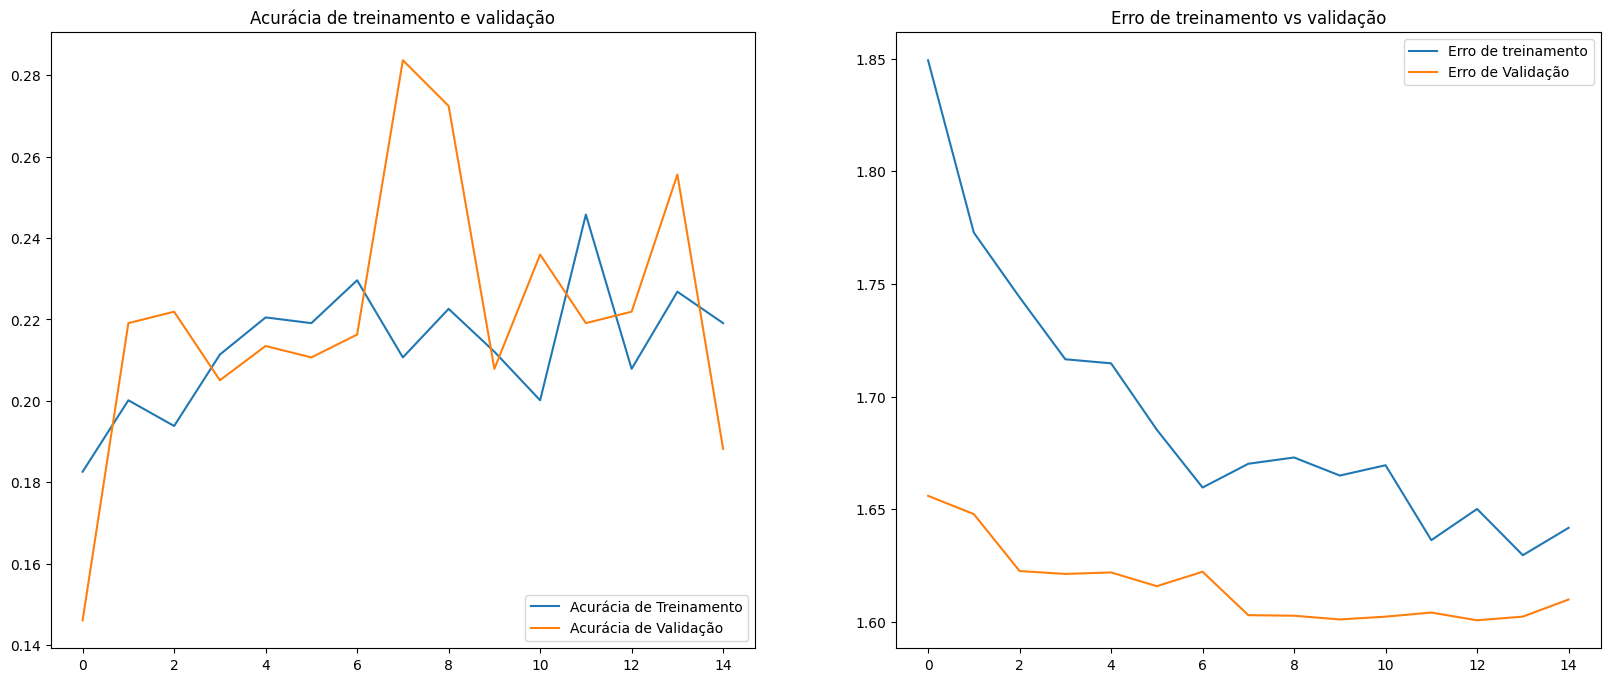

In [23]:
# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

Analisando o desempenho tanto de acurácia, a rede passa por várias ocilações durante o processo, o que pode nos mostrar que seu desempenho não iria progredir se aumentássemos o número de épocas.

Já o valor de loss (Erro), para a base de treinamento nem chegou próximo de zero, ou seja, o modelo não aprendeu bem as setenças para classificar as notícias.

## Testando com LSTM, RNN e GRU

Além de testar agora com algumas camadas da LSTM, vamos também acrescentar uma cadama GRU (Gated Recurrent Unit) que também tem o objetivo de abordar algumas das limitações das camadas RNN tradicionais, como o problema do desaparecimento do gradiente. A GRU introduz mecanismos de portão que permitem que a rede aprenda quais informações devem ser lembradas e quais podem ser esquecidas durante o processamento de sequências, bem parecida com a LSTM!

LSTM é um tipo especial de rede neural recorrente, pois são capazes de aprender conexões de longo prazo. Dessa maneira, elas têm um incrível poder de predição e funcionam muito bem em uma variada gama de problemas que envolvem capturas de padrões de longo prazo.

In [24]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True))) # acrescentando camada LSTM
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True))) # acrescentando camada LSTM
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2')) # o GRU é projetado para superar o problema do desaparecimento de gradientes nas RNNs tradicionais e é especialmente eficaz em lidar com sequências de dados temporais.
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          2293500   
                                                                 
 bidirectional_2 (Bidirecti  (None, 200, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 200, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 128)          24704     
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 198, 72)           27720     
                                                      

In [25]:
model2.compile(optimizer='adam', # Adam, que é um algoritmo de otimização amplamente utilizado para ajustar os pesos da rede neural durante o treinamento.
            loss='categorical_crossentropy', # função de perda a ser minimizada durante o treinamento
            metrics=['accuracy'] # métrica de avaliação para monitorar durante o treinamento
            )
# Configurando early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Monitora a métrica de precisão durante o treinamento
                                             patience=3, # número de épocas que o treinamento pode continuar sem melhorar a métrica monitorada antes de parar
                                              verbose=1, # mostra mensagens de progresso durante o treinamento
                                              mode='min' # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"
                                             )
# salva o modelo com os melhores valores encontrados durante o treinamento
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# treinando o modelo
history = model2.fit(train_padseq, y_train,
                   batch_size=120,
                    epochs=15,
                    validation_split=0.2
                   )

# validando o modelo
test_loss, test_acc = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 [==============================] - 19s 1s/step - loss: 8.6796 - accuracy: 0.2093 - val_loss: 7.8350 - val_accuracy: 0.2584
Epoch 2/15
12/12 [==============================] - 15s 1s/step - loss: 7.2647 - accuracy: 0.2170 - val_loss: 6.5784 - val_accuracy: 0.1966
Epoch 3/15
12/12 [==============================] - 13s 1s/step - loss: 6.0641 - accuracy: 0.2233 - val_loss: 5.4654 - val_accuracy: 0.2247
Epoch 4/15
12/12 [==============================] - 12s 998ms/step - loss: 5.0623 - accuracy: 0.2282 - val_loss: 4.5321 - val_accuracy: 0.3230
Epoch 5/15
12/12 [==============================] - 12s 992ms/step - loss: 4.1196 - accuracy: 0.3237 - val_loss: 3.6890 - val_accuracy: 0.3258
Epoch 6/15
12/12 [==============================] - 12s 1s/step - loss: 3.2851 - accuracy: 0.3722 - val_loss: 2.8587 - val_accuracy: 0.4045
Epoch 7/15
12/12 [==============================] - 13s 1s/step - loss: 2.5645 - accuracy: 0.4150 - val_loss: 2.3399 - val_accuracy: 0.4663
Epoch 8/15
12/

Uau! Dando esse "upgrade" na rede, melhorou e muito! Vamos analisar os gráficos de performance de acurácia e erro.

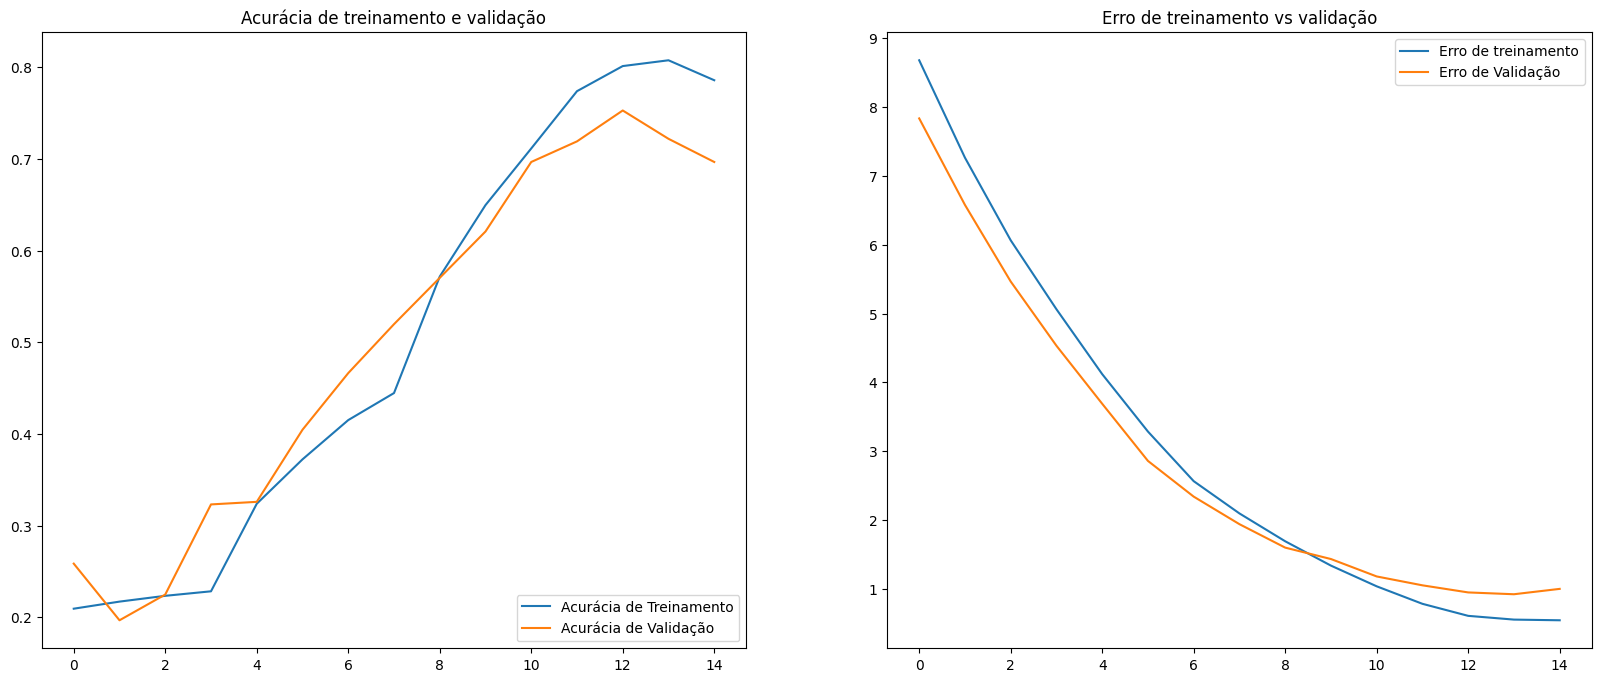

In [26]:
# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

Veja como aqui temos uma rede mais estável e com uma boa performance! Acurácia boa tanto na base treino quanto teste, e um erro baixo (quanto mais próximo de zero, melhor!)